<a href="https://colab.research.google.com/github/Zhr-Srj/TripSimAcin-AMR/blob/main/Code/TripSimAcin_AMR_validation2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this notebook we want to train TSA-Net model and validate it 10 times with strain-aside dataset and get an average over validation metrics' values.

This file includes results mentioned in Table 7 and Table 8.

# Required packages

In [ ]:
import csv
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import random
from random import sample, shuffle

from sklearn.utils import shuffle as sk_shuffle

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, confusion_matrix, accuracy_score, f1_score
from sklearn.model_selection import KFold

from tensorflow.keras.layers import Input, Dense, Dropout, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import AUC
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import LayerNormalization
from tensorflow.keras.callbacks import  History

# Data

## Loading dataset with SHAP selected features

In [ ]:
with open(r'/content/drive/MyDrive/Dataset_SHAP_u.txt') as f:
    data = []
    for line in f.readlines():
        row = []
        for elem in line.split(sep=','):
            row.append(int(elem.strip()))
        data.append(row)
print(len(data))
print(len(data[0]))

7207
2996


In [ ]:
#Reading phenotypes file
with open(r'/content/drive/MyDrive/DrugLabel_SHAP_u.txt') as fy:
    labels = []
    drugs = [] #stores drug name in each row
    row = 0 # row number of each label (is needed because data is reordered while spliting)
    reader = csv.reader(fy)
    for i in reader:
        labels.append([row, int(i[1])])
        drugs.append(i[0])
        row += 1

print(len(labels))
print(len(drugs))
print(labels[:5])

7207
7207
[[0, 1], [1, 0], [2, 0], [3, 1], [4, 1]]


In [ ]:
labels = np.asarray(labels)

## A survey on data

In [ ]:
unq_drugs = set(drugs)
len(unq_drugs)

12

In [ ]:
per_drug_dic = {}
for i, drug in enumerate(drugs_unique):
  if drug not in per_drug_dic.keys():
    per_drug_dic[drug] = [0, 0]  # num of resistant, num of susceptible
  if labels[i][1] == 0:
    per_drug_dic[drug][1] += 1
  else:
    per_drug_dic[drug][0] += 1

per_drug_dic

{'ciprofloxacin': [651, 97],
 'doripenem': [51, 148],
 'gentamicin': [572, 94],
 'tetracycline': [511, 182],
 'cefotaxime': [568, 31],
 'meropenem': [166, 172],
 'imipenem': [196, 508],
 'amikacin': [300, 394],
 'levofloxacin': [459, 146],
 'ceftriaxone': [633, 34],
 'ceftazidime': [526, 105],
 'moxifloxacin': [57, 29]}

In [ ]:
keys = []
for element in data:
  if np.asarray(element[:2693]).tobytes() not in keys:
    keys.append(np.asarray(element[:2693]).tobytes())

print("Number of strains in dataset", len(keys))

Number of strains in dataset 766


## Loading strain-aside dataset

In [ ]:
f1 = open(r'/content/drive/MyDrive/Strain_aside_Dataset_SHAP.txt')

external_test_set = []

for line in f1.readlines():
    row = []
    for elem in line.split(sep=','):
        row.append(int(elem.strip()))
    external_test_set.append(row)

print(len(external_test_set))
print(len(external_test_set[0]))

f1.close()

1371
2996


In [ ]:
#Reading phenotypes file
with open(r'/content/drive/MyDrive/Strain_aside_drugLabel_SHAP.txt') as fy:
    external_test_labels = []
    external_test_drugs = [] #stores drug name in each row
    row = 0 # row number of each label (is needed because data is reordered while spliting)
    reader = csv.reader(fy)
    for i in reader:
        external_test_labels.append([row, int(i[1])])
        external_test_drugs.append(i[0])
        row += 1

print(len(external_test_labels))
print(len(external_test_drugs))
print(external_test_labels[:5])

1371
1371
[[0, 1], [1, 1], [2, 1], [3, 1], [4, 1]]


In [ ]:
external_test_labels = np.asarray(external_test_labels)

In [ ]:
len(set(external_test_drugs))

10

In [ ]:
set(external_test_drugs)

{'amikacin',
 'cefotaxime',
 'ceftazidime',
 'ceftriaxone',
 'ciprofloxacin',
 'gentamicin',
 'imipenem',
 'levofloxacin',
 'meropenem',
 'tetracycline'}

In [ ]:
unq_drugs = set(external_test_drugs)
len(unq_drugs)

10

In [ ]:
per_drug_dic = {}
for i, drug in enumerate(external_test_drugs):
  if drug not in per_drug_dic.keys():
    per_drug_dic[drug] = [0, 0]  # num of resistant, num of susceptible
  if external_test_labels[i][1] == 0:
    per_drug_dic[drug][1] += 1
  else:
    per_drug_dic[drug][0] += 1

per_drug_dic

{'ciprofloxacin': [211, 23],
 'gentamicin': [202, 35],
 'ceftriaxone': [206, 4],
 'amikacin': [181, 26],
 'ceftazidime': [211, 14],
 'meropenem': [75, 6],
 'levofloxacin': [66, 6],
 'imipenem': [75, 6],
 'tetracycline': [14, 0],
 'cefotaxime': [10, 0]}

# Required functions

In [ ]:
def balanced_train_test_split(data, labels, drugs, n):
  """
  Performs a train_test_split, setting n susceptibles and n resistant strains aside for each drug as test set
  returns x_train, x_test, y_train, y_test
  """

  data, labels = sk_shuffle(data, labels)

  x_train = []
  x_test = []
  y_train = []
  y_test = []

  idx = {} # A dic containig indices of susceptible and resistant strain
            # for each drug

  unq_drugs = list(set(drugs))

  for drug_name in unq_drugs:
    drug_indx_S = []
    drug_indx_R = []
    for i in range(len(labels)):
      j, l = labels[i][0], labels[i][1]
      if drugs[j] == drug_name:
        if l == 0:
          drug_indx_S.append(i)
        else:
          drug_indx_R.append(i)
    idx[(drug_name, 'S')] = drug_indx_S
    idx[(drug_name, 'R')] = drug_indx_R

  len_xtrain = 0
  len_xtest = 0

  for drug in unq_drugs:

    s_set = idx[(drug, 'S')]
    for i in range(len(s_set)-n):
      x_train.append(data[s_set[i]])
      y_train.append(labels[s_set[i]])
    for i in range(1, n+1):
      x_test.append(data[s_set[-i]])
      y_test.append(labels[s_set[-i]])

    r_set = idx[(drug, 'R')]
    for i in range(len(r_set)-n):
      x_train.append(data[r_set[i]])
      y_train.append(labels[r_set[i]])
    for i in range(1, n+1):
      x_test.append(data[r_set[-i]])
      y_test.append(labels[r_set[-i]])

    # For confirming it's working properly
    print("for drug ", drug, "# of train samples: ", len(x_train)-len_xtrain, )
    len_xtrain = len(x_train)
    print("for drug ", drug, "# of test samples: ", len(x_test)-len_xtest)
    len_xtest = len(x_test)

  return x_train, x_test, y_train, y_test

In [ ]:
def make_balanced_triplets(samples, labels, drugs, num):
  """For each drug in drugs samples...
  makes:
  - n triplets which are both Susceptible to drug (S, S)
  - n triplets which are (R, R)
  - n triplets which are (S, R)
  - n triplets which are (R, S)
  """
  bac_shape = 2693

  idx = {} # A dic containig indices of susceptible and resistant strain
            # for each drug

  triplet = [] # Made from samples which are not part of external_test_sets
  triLabels = [] # Labels corresponding to triplets

  unq_drugs = list(set(drugs))

  for drug_name in unq_drugs:
    drug_indx_S = []
    drug_indx_R = []
    for i in range(len(labels)):
      j, l = labels[i][0], labels[i][1]
      if drugs[j] == drug_name:
        if l == 0:
          drug_indx_S.append(i)
        else:
          drug_indx_R.append(i)
    idx[(drug_name, 'S')] = drug_indx_S
    idx[(drug_name, 'R')] = drug_indx_R

  for drug in unq_drugs:

    s_len = len(idx[(drug, 'S')])
    r_len = len(idx[(drug, 'R')])
    n = min(num, int(s_len*(s_len-1)/2), int(r_len*(r_len-1)/2))

    ss = [(i, j) for i in idx[(drug, 'S')] for j in idx[(drug, 'S')] if j>i]
    ss_sampled = sample(ss, n)

    rr = [(i, j) for i in idx[(drug, 'R')] for j in idx[(drug, 'R')] if j>i]
    rr_sampled = sample(rr, n)

    rs = [(i, j) for i in idx[(drug, 'R')] for j in idx[(drug, 'S')]]
    neg_samples = sample(rs, 2*n)
    rs_sampled = neg_samples[:n]
    sr_sampled = [(t[1], t[0]) for t in neg_samples[n:]]

    for k in range(n):
      # Making (S, S, d) triplets
      triplet.append( samples[ss_sampled[k][0]][:bac_shape] + samples[ss_sampled[k][1]][:bac_shape] +
                        samples[ss_sampled[k][0]][bac_shape:] )
      triLabels.append([1, 0]) # 1: both phenos the same. First: 0, sencond? --> 0

      # Making (R, R, d) triplets
      triplet.append( samples[rr_sampled[k][0]][:bac_shape] + samples[rr_sampled[k][1]][:bac_shape] +
                        samples[rr_sampled[k][0]][bac_shape:] )
      triLabels.append([1, 1]) # 1: both phenos the same. First: 1, sencond? --> 1

      # Making (R, S, d) triplets
      triplet.append( samples[rs_sampled[k][0]][:bac_shape] + samples[rs_sampled[k][1]][:bac_shape] +
                         samples[rs_sampled[k][0]][bac_shape:])
      triLabels.append([0, 1]) # 0: phenos different. First: 1, sencond? --> 0

      # Making (S, R, d) triplets
      triplet.append( samples[sr_sampled[k][0]][:bac_shape] + samples[sr_sampled[k][1]][:bac_shape] +
                         samples[sr_sampled[k][0]][bac_shape:])
      triLabels.append([0, 0]) # 0: phenos different. First: 0, sencond? --> 1

  return np.array(triplet), np.array(triLabels)

In [ ]:
def evaluation(true_labels, pred_labels):

  Dis_pred = []
  for i in pred_labels:
    if i < 0.5:
      Dis_pred.append(0)
    else:
      Dis_pred.append(1)

  acc = accuracy_score(true_labels, Dis_pred)
  auc = roc_auc_score(true_labels, Dis_pred)
  print('Accuracy: ', acc)
  print('ROC-AUC: ', auc)

  TN, FP, FN, TP = confusion_matrix(true_labels, Dis_pred, labels=[0, 1]).ravel()
  sen = TP/(TP+FN)
  spc = TN/(TN+FP)
  print("Sensitivity: ", sen)
  print('Specificity: ', spc)

  conf_matrix = confusion_matrix(true_labels, Dis_pred, labels=[0, 1])
  plt.figure(figsize=(4, 4))
  sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
              xticklabels=['Predicted Negative', 'Predicted Positive'],
              yticklabels=['True Negative', 'True Positive'])
  plt.xlabel('Predicted')
  plt.ylabel('Actual')
  plt.title('Confusion Matrix')
  plt.show()

  return acc, auc, sen, spc

# TripSimAcin-AMR framework

## TSA-Net architecture

In [ ]:
input_shape1 = (2693,) # Strain feature vector length
input_shape2 = (2693,)
input_shape3 = (303,) # Antibiotic feature vector length

In [ ]:
def create_siamese_model(input_shape1, input_shape2, input_shape3):

    right_input = Input(shape=input_shape2)
    left_input = Input(shape=input_shape1)
    third_input = Input(shape=input_shape3)

    shared_layer1 = Dense(1024, activation='leaky_relu')
    shared_layer2 = Dense(512, activation='leaky_relu')
    shared_layer3 = Dense(256, activation='leaky_relu')
    shared_bn = BatchNormalization() # shared batch normalization layer
    drug_bn = BatchNormalization() # drug batch normalization layer

    encoded_l = shared_layer1(left_input)
    encoded_l = Dropout(0.2)(encoded_l)
    encoded_l = shared_layer2(encoded_l)
    encoded_l = Dropout(0.2)(encoded_l)
    encoded_l = shared_layer3(encoded_l)
    encoded_l = Dropout(0.2)(encoded_l)
    encoded_l = shared_bn(encoded_l)

    encoded_r = shared_layer1(right_input)
    encoded_r = Dropout(0.2)(encoded_r)
    encoded_r = shared_layer2(encoded_r)
    encoded_r = Dropout(0.2)(encoded_r)
    encoded_r = shared_layer3(encoded_r)
    encoded_r = Dropout(0.2)(encoded_r)
    encoded_r = shared_bn(encoded_r)

    encoded_c = Dense(256, activation='leaky_relu')(third_input)
    encoded_c = Dropout(0.2)(encoded_c)
    encoded_c = drug_bn(encoded_c)

    concatenated = Concatenate()([encoded_l, encoded_r, encoded_c])

    dense1 = Dense(128, activation='leaky_relu')(concatenated)
    dense1 = Dropout(0.2)(dense1)
    dense2 = Dense(32, activation='leaky_relu')(dense1)
    dense2 = Dropout(0.2)(dense2)
    prediction = Dense(1, activation='sigmoid')(dense2)

    siamese_net = Model(inputs=[left_input, right_input, third_input], outputs=prediction)

    optimizer = Adam(learning_rate=0.001)
    siamese_net.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=["accuracy", AUC(name='auc-roc')])

    return siamese_net

# Evaluation

## Functions
Performance on queries

So each label is a list of size 2

In [ ]:
def ExternalTest(x0_test,x1_test,x0_train,x1_train):
  """
  Takes as input paired data and
  Pairs each test sample with train samples of the same drug (triplet --> b1, b2, d).
  x0_test: test samples with phenotype 0
  x1_test: test samples with phenotype 1
  x0_train: train samples with phenotype 0
  x1_train: train samples with phenotype 1
  """
  dataset_test1=[] # concat train
  label_test1=[]
  Indexsample=[]

  for i in range(len(x0_test)):
    for j in range(len(x0_train)):
      if (x0_test[i][2693:] == x0_train[j][2693:]).all():
        dataset_test1.append(np.concatenate((x0_test[i][0:2693],x0_train[j]), axis=None))
        label_test1.append(1)
        Indexsample.append(str(i)+",0,0")   #index in test, x0_test pheno, x0_train pheno

  for i in range(len(x0_test)):
    for j in range(len(x1_train)):
      if (x0_test[i][2693:] == x1_train[j][2693:]).all():
        dataset_test1.append(np.concatenate((x0_test[i][0:2693],x1_train[j]), axis=None))
        label_test1.append(0)
        Indexsample.append(str(i)+",0,1")   #index in test, x0_test pheno, x1_train pheno

  for i in range(len(x1_test)):
    for j in range(len(x0_train)):
      if (x1_test[i][2693:] == x0_train[j][2693:]).all():
        dataset_test1.append(np.concatenate((x1_test[i][0:2693],x0_train[j]), axis=None))
        label_test1.append(0)
        Indexsample.append(str(i)+",1,0")  #index in test,x1_test,x0_train

  for i in range(len(x1_test)):
    for j in range(len(x1_train)):
      if (x1_test[i][2693:] == x1_train[j][2693:]).all():
        dataset_test1.append(np.concatenate((x1_test[i][0:2693],x1_train[j]), axis=None))
        label_test1.append(1)
        Indexsample.append(str(i)+",1,1")  #index in test,x1_test,x1_train

  return (np.asarray(dataset_test1), np.asarray(label_test1), Indexsample)

In [ ]:
def DefineTest2(x0_test, x1_test, Indexsample, y_pred):

  """
  Aggregates labels predicted by TSA_Net to get a unified prediction of resistence
  phenotype (Desired output for TripSimAcin_AMR)
  """
  Pred=[]
  Label=[]

  # START of x0_test
  for i in range(len(x0_test)):
    cnt0Pred=0
    cnt1Pred=0
    cnt1=0
    cnt0=0

    for j in range(len(Indexsample)):
      triplet=Indexsample[j].split(",")   #pair[0] is index from test, pair[1] identifies which test x0_test or s1_test, pair[2] identifies which x0
      if int(triplet[0])==i: #index test
        if int(triplet[1])==0: #type test

          if int(triplet[2])==1: #type train
              cnt1Pred=cnt1Pred+y_pred[j]
              cnt1=cnt1+1

          if int(triplet[2])==0: #type train
              cnt0Pred=cnt0Pred+y_pred[j]
              cnt0=cnt0+1

    pos=(1-(cnt0Pred/cnt0))+(cnt1Pred/cnt1)
    neg=(cnt0Pred/cnt0)+(1-(cnt1Pred/cnt1))
    Pred.append(pos/(pos+neg))
    Label.append(0)

  # END of x0_test
  ######################################################
  # START of x1_test
  for i in range(len(x1_test)):
    cnt0Pred=0
    cnt1Pred=0
    cnt1=0
    cnt0=0
    for j in range(len(Indexsample)):
      triplet=Indexsample[j].split(",")   #pair[0] is index from test, pair[1] identifies which test x0_test or s1_test, pair[2] identifies which x0
      if int(triplet[0])==i: #index test
        if int(triplet[1])==1: #type test

          if int(triplet[2])==0: #type train
              cnt0Pred=cnt0Pred+y_pred[j]
              cnt0=cnt0+1

          if int(triplet[2])==1: #type train
              cnt1Pred=cnt1Pred+y_pred[j]
              cnt1=cnt1+1

    pos=(1-(cnt0Pred/cnt0))+(cnt1Pred/cnt1)
    neg=(cnt0Pred/cnt0)+(1-(cnt1Pred/cnt1))
    Pred.append(pos/(pos+neg))
    Label.append(1)

  return(Pred,Label)

In [ ]:
def RS_splitter(data, labels):
  """
  Takes as input a dataset and corresponding labels
  returns data0, data1
  which are set of susceptible and resistant strains in data, respectively
  """
  data0 = [] # list of susceptible strains' features
  data1 = [] # list of resistant strains' features
  index0 = [] # indices in original data
  index1 = [] # indices in original data

  for i, l in enumerate(labels):
    if l[1] == 0:
      data0.append(data[i])
      index0.append(l[0])
    else:
      data1.append(data[i])
      index1.append(l[0])

  return data0, data1, index0, index1

In [ ]:
sim_acc = []
sim_auc = []
sim_sen = []
sim_spc = []

phen_acc = []
phen_auc = []
phen_sen = []
phen_spc = []

# Round 1

In [ ]:
# Making triplets
triplet, pairedLabels =  make_balanced_triplets(data, labels, drugs, 400)

In [ ]:
print(len(triplet))
print(len(triplet[0]))
print(len(pairedLabels))
print(pairedLabels[0])

19200
5689
19200
[1 0]


Preparing data

In [ ]:
triplet = np.asarray(triplet)
triplet.shape

(19200, 5689)

In [ ]:
pairedLabels = np.asarray(pairedLabels)
pairedLabels.shape

(19200, 2)

Training

In [ ]:
siamese_net = create_siamese_model(input_shape1, input_shape2, input_shape3)

In [ ]:
num_epochs=10
history=History()
siamese_net = create_siamese_model(input_shape1, input_shape2, input_shape3)

print("Round: 1 ---> 1-10")
history = siamese_net.fit([[triplet[:, :2693],
                           triplet[:, 2693:(2693+2693)]],
                           triplet[:, (2693+2693):]], pairedLabels[:, 0],
                          epochs=num_epochs, batch_size=64, verbose=1, callbacks=history)

for i in range(25-1):
  print("Round: ", i+2, '--->', (i+1)*10+1, '-', (i+2)*10)

  triplet, pairedLabels =  make_balanced_triplets(data, labels, drugs, 400)

  history = siamese_net.fit([[triplet[:, :2693],
                           triplet[:, 2693:(2693+2693)]],
                           triplet[:, (2693+2693):]], pairedLabels[:, 0],
                          epochs=num_epochs, batch_size=64, verbose=1, callbacks=history)

Round: 1 ---> 1-10
Epoch 1/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step - accuracy: 0.4971 - auc-roc: 0.4987 - loss: 0.7862
Epoch 2/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.4990 - auc-roc: 0.4982 - loss: 0.7080
Epoch 3/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.4932 - auc-roc: 0.4895 - loss: 0.7037
Epoch 4/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.4949 - auc-roc: 0.4929 - loss: 0.6999
Epoch 5/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.5016 - auc-roc: 0.5071 - loss: 0.6956
Epoch 6/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.4961 - auc-roc: 0.4976 - loss: 0.6961
Epoch 7/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.4975 - auc-roc: 0.4955 - loss: 0.6951
Epoch 8/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.5108 - auc-roc: 0.5176 - loss: 0.6899
Epoch 9/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.7328 - auc-roc: 0.8249 - loss: 0.5108
Epoch 10/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s

## Validation

In [ ]:
test_labels = np.asarray(external_test_labels)
train_labels = np.asarray(labels)

In [ ]:
# splitting external_test_set to set of susceptible and resistant ones:
x0_test, x1_test, index0_test, index1_test = RS_splitter(external_test_set, test_labels)

In [ ]:
print(len(x0_test))
print(len(x0_test[0]))
print(len(x1_test))
print(len(x1_test[0]))

120
2996
1251
2996


In [ ]:
x0_train, x1_train, index0_train, index1_train = RS_splitter(data, labels)

In [ ]:
print(len(x0_train))
print(len(x0_train[0]))
print(len(x1_train))
print(len(x1_train[0]))

1940
2996
4690
2996


In [ ]:
x0_train = np.asarray(x0_train)
x1_train = np.asarray(x1_train)

## Procedure (Per test sample)

In [ ]:
test_labels = []  # True labels for test samples.
aggre_preds = [] # Aggregated pred values for each sample, by DefineTest2 func.
internal_labels = [] # Labels form ExternalTest2 for internal test
internal_preds = [] # internal_labels corresponding predictions
test_indices = []

for c, i in enumerate(x0_test):      #x0_test, x1_test, x0_train, x1_train
  data, labels, indexSample = ExternalTest([i], [], x0_train, x1_train) # makes i couple with x0_train & x1_train
  internal_labels += labels.tolist()
  predd = siamese_net.predict([[data[:, :2693],
                           data[:, 2693:(2693+2693)]],
                           data[:, (2693+2693):]], verbose=0)
  internal_preds += predd.tolist()
  y_pred, label = DefineTest2([i], [], indexSample, predd)
  aggre_preds.append(y_pred[0][0]) # y_pred ---> [array([0.5], dtype=float32)]
  test_labels.append(label[0])
  test_indices.append(index0_test[c]) # Index in original data


for c, i in enumerate(x1_test):
  data, labels, indexSample = ExternalTest([], [i], x0_train, x1_train)
  internal_labels += labels.tolist()
  predd = siamese_net.predict([[data[:, :2693],
                           data[:, 2693:(2693+2693)]],
                           data[:, (2693+2693):]], verbose=0)
  internal_preds += predd.tolist()
  y_pred, label = DefineTest2([], [i], indexSample, predd)
  aggre_preds.append(y_pred[0][0])
  test_labels.append(label[0])
  test_indices.append(index1_test[c]) # Index in original data

In [ ]:
temp = [i[0] for i in internal_preds]
internal_preds = temp

## TSA-Net evaluation

(Similarity test)

Accuracy:  0.8950390753587496
ROC-AUC:  0.8624242125892183
Sensitivity:  0.9398294431950392
Specificity:  0.785018981983397


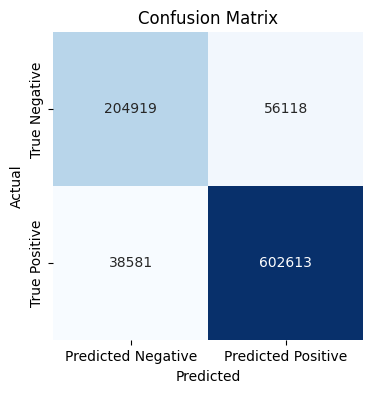

In [ ]:
acc, auc, sen, spc = evaluation(internal_labels, internal_preds)

In [ ]:
sim_acc.append(acc)
sim_auc.append(auc)
sim_sen.append(sen)
sim_spc.append(spc)

## TripSimAcin-AMR evaluation

(Phenotype prediction test)

Accuracy:  0.9022611232676878
ROC-AUC:  0.8221322941646683
Sensitivity:  0.9192645883293366
Specificity:  0.725


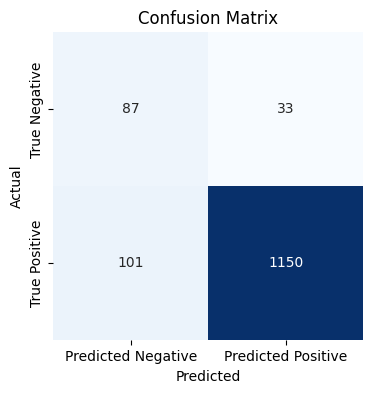

In [ ]:
acc, auc, sen, spc = evaluation(test_labels, aggre_preds)

In [ ]:
phen_acc.append(acc)
phen_auc.append(auc)
phen_sen.append(sen)
phen_spc.append(spc)

# Round 2

In [ ]:
# Making triplets
triplet, pairedLabels =  make_balanced_triplets(data, labels, drugs, 400)

In [ ]:
print(len(triplet))
print(len(triplet[0]))
print(len(pairedLabels))
print(pairedLabels[0])

19200
5689
19200
[1 0]


Preparing data

In [ ]:
triplet = np.asarray(triplet)
triplet.shape

(19200, 5689)

In [ ]:
pairedLabels = np.asarray(pairedLabels)
pairedLabels.shape

(19200, 2)

Training

In [ ]:
siamese_net = create_siamese_model(input_shape1, input_shape2, input_shape3)

In [ ]:
num_epochs=10
history=History()
siamese_net = create_siamese_model(input_shape1, input_shape2, input_shape3)

print("Round: 1 ---> 1-10")
history = siamese_net.fit([[triplet[:, :2693],
                           triplet[:, 2693:(2693+2693)]],
                           triplet[:, (2693+2693):]], pairedLabels[:, 0],
                          epochs=num_epochs, batch_size=64, verbose=1, callbacks=history)

for i in range(25-1):
  print("Round: ", i+2, '--->', (i+1)*10+1, '-', (i+2)*10)

  triplet, pairedLabels =  make_balanced_triplets(data, labels, drugs, 400)

  history = siamese_net.fit([[triplet[:, :2693],
                           triplet[:, 2693:(2693+2693)]],
                           triplet[:, (2693+2693):]], pairedLabels[:, 0],
                          epochs=num_epochs, batch_size=64, verbose=1, callbacks=history)

Round: 1 ---> 1-10
Epoch 1/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - accuracy: 0.4958 - auc-roc: 0.4983 - loss: 0.7777
Epoch 2/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.5081 - auc-roc: 0.5032 - loss: 0.7088
Epoch 3/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.5011 - auc-roc: 0.5005 - loss: 0.7022
Epoch 4/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.4994 - auc-roc: 0.5031 - loss: 0.6988
Epoch 5/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.5040 - auc-roc: 0.5048 - loss: 0.6966
Epoch 6/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.5302 - auc-roc: 0.5516 - loss: 0.6790
Epoch 7/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.7413 - auc-roc: 0.8363 - loss: 0.4949
Epoch 8/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.7672 - auc-roc: 0.8647 - loss: 0.4546
Epoch 9/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.7839 - auc-roc: 0.8784 - loss: 0.4352
Epoch 10/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 3s 

## Validation

In [ ]:
test_labels = np.asarray(external_test_labels)
train_labels = np.asarray(labels)

In [ ]:
# splitting external_test_set to set of susceptible and resistant ones:
x0_test, x1_test, index0_test, index1_test = RS_splitter(external_test_set, test_labels)

In [ ]:
print(len(x0_test))
print(len(x0_test[0]))
print(len(x1_test))
print(len(x1_test[0]))

120
2996
1251
2996


In [ ]:
x0_train, x1_train, index0_train, index1_train = RS_splitter(data, labels)

In [ ]:
print(len(x0_train))
print(len(x0_train[0]))
print(len(x1_train))
print(len(x1_train[0]))

1940
2996
4690
2996


In [ ]:
x0_train = np.asarray(x0_train)
x1_train = np.asarray(x1_train)

## Procedure (Per test sample)

In [ ]:
test_labels = []  # True labels for test samples.
aggre_preds = [] # Aggregated pred values for each sample, by DefineTest2 func.
internal_labels = [] # Labels form ExternalTest2 for internal test
internal_preds = [] # internal_labels corresponding predictions
test_indices = []

for c, i in enumerate(x0_test):      #x0_test, x1_test, x0_train, x1_train
  data, labels, indexSample = ExternalTest([i], [], x0_train, x1_train) # makes i couple with x0_train & x1_train
  internal_labels += labels.tolist()
  predd = siamese_net.predict([[data[:, :2693],
                           data[:, 2693:(2693+2693)]],
                           data[:, (2693+2693):]], verbose=0)
  internal_preds += predd.tolist()
  y_pred, label = DefineTest2([i], [], indexSample, predd)
  aggre_preds.append(y_pred[0][0]) # y_pred ---> [array([0.5], dtype=float32)]
  test_labels.append(label[0])
  test_indices.append(index0_test[c]) # Index in original data


for c, i in enumerate(x1_test):
  data, labels, indexSample = ExternalTest([], [i], x0_train, x1_train)
  internal_labels += labels.tolist()
  predd = siamese_net.predict([[data[:, :2693],
                           data[:, 2693:(2693+2693)]],
                           data[:, (2693+2693):]], verbose=0)
  internal_preds += predd.tolist()
  y_pred, label = DefineTest2([], [i], indexSample, predd)
  aggre_preds.append(y_pred[0][0])
  test_labels.append(label[0])
  test_indices.append(index1_test[c]) # Index in original data

In [ ]:
temp = [i[0] for i in internal_preds]
internal_preds = temp

## TSA-Net evaluation

(Similarity test)

Accuracy:  0.8899738537026549
ROC-AUC:  0.857765789584257
Sensitivity:  0.9342055602516555
Specificity:  0.7813260189168585


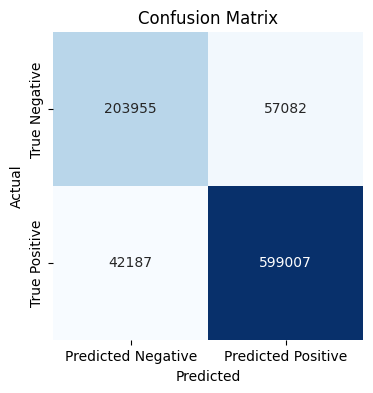

In [ ]:
acc, auc, sen, spc = evaluation(internal_labels, internal_preds)

In [ ]:
sim_acc.append(acc)
sim_auc.append(auc)
sim_sen.append(sen)
sim_spc.append(spc)

## TripSimAcin-AMR evaluation

(Phenotype prediction test)

Accuracy:  0.8956965718453683
ROC-AUC:  0.7959332533972823
Sensitivity:  0.9168665067945644
Specificity:  0.675


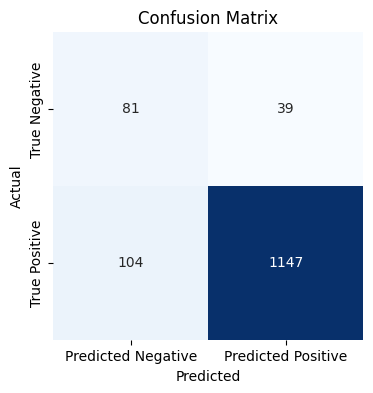

In [ ]:
acc, auc, sen, spc = evaluation(test_labels, aggre_preds)

In [ ]:
phen_acc.append(acc)
phen_auc.append(auc)
phen_sen.append(sen)
phen_spc.append(spc)

# Round 3

In [ ]:
# Making triplets
triplet, pairedLabels =  make_balanced_triplets(data, labels, drugs, 400)

In [ ]:
print(len(triplet))
print(len(triplet[0]))
print(len(pairedLabels))
print(pairedLabels[0])

19200
5689
19200
[1 0]


Preparing data

In [ ]:
triplet = np.asarray(triplet)
triplet.shape

(19200, 5689)

In [ ]:
pairedLabels = np.asarray(pairedLabels)
pairedLabels.shape

(19200, 2)

Training

In [ ]:
siamese_net = create_siamese_model(input_shape1, input_shape2, input_shape3)

In [ ]:
num_epochs=10
history=History()
siamese_net = create_siamese_model(input_shape1, input_shape2, input_shape3)

print("Round: 1 ---> 1-10")
history = siamese_net.fit([[triplet[:, :2693],
                           triplet[:, 2693:(2693+2693)]],
                           triplet[:, (2693+2693):]], pairedLabels[:, 0],
                          epochs=num_epochs, batch_size=64, verbose=1, callbacks=history)

for i in range(25-1):
  print("Round: ", i+2, '--->', (i+1)*10+1, '-', (i+2)*10)

  triplet, pairedLabels =  make_balanced_triplets(data, labels, drugs, 400)

  history = siamese_net.fit([[triplet[:, :2693],
                           triplet[:, 2693:(2693+2693)]],
                           triplet[:, (2693+2693):]], pairedLabels[:, 0],
                          epochs=num_epochs, batch_size=64, verbose=1, callbacks=history)

Round: 1 ---> 1-10
Epoch 1/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step - accuracy: 0.4981 - auc-roc: 0.4971 - loss: 0.7824
Epoch 2/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.5043 - auc-roc: 0.5026 - loss: 0.7103
Epoch 3/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.5058 - auc-roc: 0.5076 - loss: 0.6996
Epoch 4/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.7049 - auc-roc: 0.7933 - loss: 0.5397
Epoch 5/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.7500 - auc-roc: 0.8462 - loss: 0.4810
Epoch 6/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.7749 - auc-roc: 0.8700 - loss: 0.4494
Epoch 7/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.8013 - auc-roc: 0.8910 - loss: 0.4174
Epoch 8/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8181 - auc-roc: 0.9075 - loss: 0.3829
Epoch 9/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.8283 - auc-roc: 0.9175 - loss: 0.3659
Epoch 10/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 

## Validation

In [ ]:
test_labels = np.asarray(external_test_labels)
train_labels = np.asarray(labels)

In [ ]:
# splitting external_test_set to set of susceptible and resistant ones:
x0_test, x1_test, index0_test, index1_test = RS_splitter(external_test_set, test_labels)

In [ ]:
print(len(x0_test))
print(len(x0_test[0]))
print(len(x1_test))
print(len(x1_test[0]))

120
2996
1251
2996


In [ ]:
x0_train, x1_train, index0_train, index1_train = RS_splitter(data, labels)

In [ ]:
print(len(x0_train))
print(len(x0_train[0]))
print(len(x1_train))
print(len(x1_train[0]))

1940
2996
4690
2996


In [ ]:
x0_train = np.asarray(x0_train)
x1_train = np.asarray(x1_train)

## Procedure (Per test sample)

In [ ]:
test_labels = []  # True labels for test samples.
aggre_preds = [] # Aggregated pred values for each sample, by DefineTest2 func.
internal_labels = [] # Labels form ExternalTest2 for internal test
internal_preds = [] # internal_labels corresponding predictions
test_indices = []

for c, i in enumerate(x0_test):      #x0_test, x1_test, x0_train, x1_train
  data, labels, indexSample = ExternalTest([i], [], x0_train, x1_train) # makes i couple with x0_train & x1_train
  internal_labels += labels.tolist()
  predd = siamese_net.predict([[data[:, :2693],
                           data[:, 2693:(2693+2693)]],
                           data[:, (2693+2693):]], verbose=0)
  internal_preds += predd.tolist()
  y_pred, label = DefineTest2([i], [], indexSample, predd)
  aggre_preds.append(y_pred[0][0]) # y_pred ---> [array([0.5], dtype=float32)]
  test_labels.append(label[0])
  test_indices.append(index0_test[c]) # Index in original data


for c, i in enumerate(x1_test):
  data, labels, indexSample = ExternalTest([], [i], x0_train, x1_train)
  internal_labels += labels.tolist()
  predd = siamese_net.predict([[data[:, :2693],
                           data[:, 2693:(2693+2693)]],
                           data[:, (2693+2693):]], verbose=0)
  internal_preds += predd.tolist()
  y_pred, label = DefineTest2([], [i], indexSample, predd)
  aggre_preds.append(y_pred[0][0])
  test_labels.append(label[0])
  test_indices.append(index1_test[c]) # Index in original data

In [ ]:
temp = [i[0] for i in internal_preds]
internal_preds = temp

## TSA-Net evaluation

(Similarity test)

Accuracy:  0.8803754249188955
ROC-AUC:  0.8490526449680165
Sensitivity:  0.9233913604930801
Specificity:  0.7747139294429526


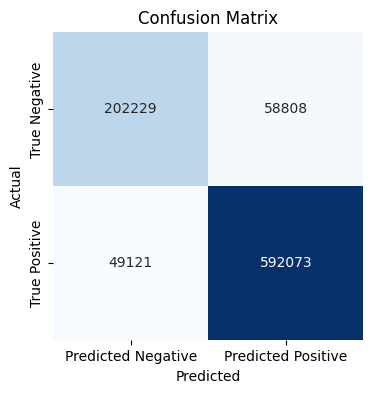

In [ ]:
acc, auc, sen, spc = evaluation(internal_labels, internal_preds)

In [ ]:
sim_acc.append(acc)
sim_auc.append(auc)
sim_sen.append(sen)
sim_spc.append(spc)

## TripSimAcin-AMR evaluation

(Phenotype prediction test)

Accuracy:  0.8913202042304887
ROC-AUC:  0.79353517186251
Sensitivity:  0.9120703437250199
Specificity:  0.675


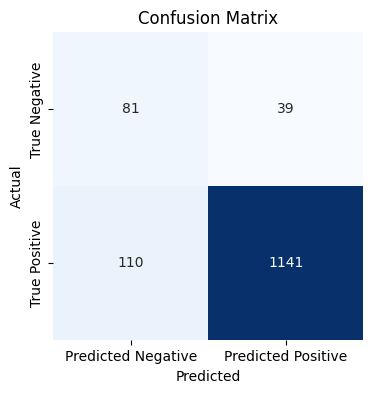

In [ ]:
acc, auc, sen, spc = evaluation(test_labels, aggre_preds)

In [ ]:
phen_acc.append(acc)
phen_auc.append(auc)
phen_sen.append(sen)
phen_spc.append(spc)

# Round 4

In [ ]:
# Making triplets
triplet, pairedLabels =  make_balanced_triplets(data, labels, drugs, 400)

In [ ]:
print(len(triplet))
print(len(triplet[0]))
print(len(pairedLabels))
print(pairedLabels[0])

19200
5689
19200
[1 0]


Preparing data

In [ ]:
triplet = np.asarray(triplet)
triplet.shape

(19200, 5689)

In [ ]:
pairedLabels = np.asarray(pairedLabels)
pairedLabels.shape

(19200, 2)

Training

In [ ]:
siamese_net = create_siamese_model(input_shape1, input_shape2, input_shape3)

In [ ]:
num_epochs=10
history=History()
siamese_net = create_siamese_model(input_shape1, input_shape2, input_shape3)

print("Round: 1 ---> 1-10")
history = siamese_net.fit([[triplet[:, :2693],
                           triplet[:, 2693:(2693+2693)]],
                           triplet[:, (2693+2693):]], pairedLabels[:, 0],
                          epochs=num_epochs, batch_size=64, verbose=1, callbacks=history)

for i in range(25-1):
  print("Round: ", i+2, '--->', (i+1)*10+1, '-', (i+2)*10)

  triplet, pairedLabels =  make_balanced_triplets(data, labels, drugs, 400)

  history = siamese_net.fit([[triplet[:, :2693],
                           triplet[:, 2693:(2693+2693)]],
                           triplet[:, (2693+2693):]], pairedLabels[:, 0],
                          epochs=num_epochs, batch_size=64, verbose=1, callbacks=history)

Round: 1 ---> 1-10
Epoch 1/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - accuracy: 0.5072 - auc-roc: 0.5040 - loss: 0.7693
Epoch 2/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.5026 - auc-roc: 0.4984 - loss: 0.7086
Epoch 3/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.4936 - auc-roc: 0.4932 - loss: 0.7032
Epoch 4/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5030 - auc-roc: 0.5017 - loss: 0.6989
Epoch 5/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5099 - auc-roc: 0.5079 - loss: 0.6958
Epoch 6/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5021 - auc-roc: 0.5022 - loss: 0.6961
Epoch 7/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.5277 - auc-roc: 0.5403 - loss: 0.6833
Epoch 8/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.7387 - auc-roc: 0.8333 - loss: 0.4969
Epoch 9/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.7581 - auc-roc: 0.8579 - loss: 0.4629
Epoch 10/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 6s

## Validation

In [ ]:
test_labels = np.asarray(external_test_labels)
train_labels = np.asarray(labels)

In [ ]:
# splitting external_test_set to set of susceptible and resistant ones:
x0_test, x1_test, index0_test, index1_test = RS_splitter(external_test_set, test_labels)

In [ ]:
print(len(x0_test))
print(len(x0_test[0]))
print(len(x1_test))
print(len(x1_test[0]))

120
2996
1251
2996


In [ ]:
x0_train, x1_train, index0_train, index1_train = RS_splitter(data, labels)

In [ ]:
print(len(x0_train))
print(len(x0_train[0]))
print(len(x1_train))
print(len(x1_train[0]))

1940
2996
4690
2996


In [ ]:
x0_train = np.asarray(x0_train)
x1_train = np.asarray(x1_train)

## Procedure (Per test sample)

In [ ]:
test_labels = []  # True labels for test samples.
aggre_preds = [] # Aggregated pred values for each sample, by DefineTest2 func.
internal_labels = [] # Labels form ExternalTest2 for internal test
internal_preds = [] # internal_labels corresponding predictions
test_indices = []

for c, i in enumerate(x0_test):      #x0_test, x1_test, x0_train, x1_train
  data, labels, indexSample = ExternalTest([i], [], x0_train, x1_train) # makes i couple with x0_train & x1_train
  internal_labels += labels.tolist()
  predd = siamese_net.predict([[data[:, :2693],
                           data[:, 2693:(2693+2693)]],
                           data[:, (2693+2693):]], verbose=0)
  internal_preds += predd.tolist()
  y_pred, label = DefineTest2([i], [], indexSample, predd)
  aggre_preds.append(y_pred[0][0]) # y_pred ---> [array([0.5], dtype=float32)]
  test_labels.append(label[0])
  test_indices.append(index0_test[c]) # Index in original data


for c, i in enumerate(x1_test):
  data, labels, indexSample = ExternalTest([], [i], x0_train, x1_train)
  internal_labels += labels.tolist()
  predd = siamese_net.predict([[data[:, :2693],
                           data[:, 2693:(2693+2693)]],
                           data[:, (2693+2693):]], verbose=0)
  internal_preds += predd.tolist()
  y_pred, label = DefineTest2([], [i], indexSample, predd)
  aggre_preds.append(y_pred[0][0])
  test_labels.append(label[0])
  test_indices.append(index1_test[c]) # Index in original data

In [ ]:
temp = [i[0] for i in internal_preds]
internal_preds = temp

## TSA-Net evaluation

(Similarity test)

Accuracy:  0.8907219991332597
ROC-AUC:  0.8654012707650702
Sensitivity:  0.9254952479280841
Specificity:  0.8053072936020564


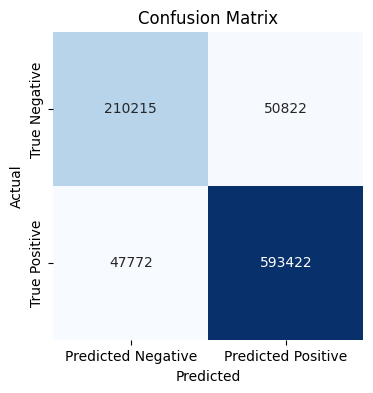

In [ ]:
acc, auc, sen, spc = evaluation(internal_labels, internal_preds)

In [ ]:
sim_acc.append(acc)
sim_auc.append(auc)
sim_sen.append(sen)
sim_spc.append(spc)

## TripSimAcin-AMR evaluation

(Phenotype prediction test)

Accuracy:  0.9008023340627279
ROC-AUC:  0.813798960831335
Sensitivity:  0.9192645883293366
Specificity:  0.7083333333333334


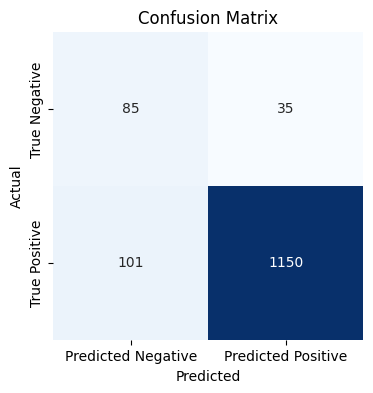

In [ ]:
acc, auc, sen, spc = evaluation(test_labels, aggre_preds)

In [ ]:
phen_acc.append(acc)
phen_auc.append(auc)
phen_sen.append(sen)
phen_spc.append(spc)

# Round 5

In [ ]:
# Making triplets
triplet, pairedLabels =  make_balanced_triplets(data, labels, drugs, 400)

In [ ]:
print(len(triplet))
print(len(triplet[0]))
print(len(pairedLabels))
print(pairedLabels[0])

19200
5689
19200
[1 0]


Preparing data

In [ ]:
triplet = np.asarray(triplet)
triplet.shape

(19200, 5689)

In [ ]:
pairedLabels = np.asarray(pairedLabels)
pairedLabels.shape

(19200, 2)

Training

In [ ]:
siamese_net = create_siamese_model(input_shape1, input_shape2, input_shape3)

In [ ]:
num_epochs=10
history=History()
siamese_net = create_siamese_model(input_shape1, input_shape2, input_shape3)

print("Round: 1 ---> 1-10")
history = siamese_net.fit([[triplet[:, :2693],
                           triplet[:, 2693:(2693+2693)]],
                           triplet[:, (2693+2693):]], pairedLabels[:, 0],
                          epochs=num_epochs, batch_size=64, verbose=1, callbacks=history)

for i in range(25-1):
  print("Round: ", i+2, '--->', (i+1)*10+1, '-', (i+2)*10)

  triplet, pairedLabels =  make_balanced_triplets(data, labels, drugs, 400)

  history = siamese_net.fit([[triplet[:, :2693],
                           triplet[:, 2693:(2693+2693)]],
                           triplet[:, (2693+2693):]], pairedLabels[:, 0],
                          epochs=num_epochs, batch_size=64, verbose=1, callbacks=history)

Round: 1 ---> 1-10
Epoch 1/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.5006 - auc-roc: 0.4982 - loss: 0.8063
Epoch 2/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.4987 - auc-roc: 0.4983 - loss: 0.7134
Epoch 3/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5000 - auc-roc: 0.5006 - loss: 0.7040
Epoch 4/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5004 - auc-roc: 0.4993 - loss: 0.7011
Epoch 5/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.5002 - auc-roc: 0.5013 - loss: 0.6981
Epoch 6/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5153 - auc-roc: 0.5213 - loss: 0.6919
Epoch 7/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.7323 - auc-roc: 0.8235 - loss: 0.5131
Epoch 8/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.7547 - auc-roc: 0.8568 - loss: 0.4642
Epoch 9/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7756 - auc-roc: 0.8710 - loss: 0.4484
Epoch 10/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 3s 

## Validation

In [ ]:
test_labels = np.asarray(external_test_labels)
train_labels = np.asarray(labels)

In [ ]:
# splitting external_test_set to set of susceptible and resistant ones:
x0_test, x1_test, index0_test, index1_test = RS_splitter(external_test_set, test_labels)

In [ ]:
print(len(x0_test))
print(len(x0_test[0]))
print(len(x1_test))
print(len(x1_test[0]))

120
2996
1251
2996


In [ ]:
x0_train, x1_train, index0_train, index1_train = RS_splitter(data, labels)

In [ ]:
print(len(x0_train))
print(len(x0_train[0]))
print(len(x1_train))
print(len(x1_train[0]))

1940
2996
4690
2996


In [ ]:
x0_train = np.asarray(x0_train)
x1_train = np.asarray(x1_train)

## Procedure (Per test sample)

In [ ]:
test_labels = []  # True labels for test samples.
aggre_preds = [] # Aggregated pred values for each sample, by DefineTest2 func.
internal_labels = [] # Labels form ExternalTest2 for internal test
internal_preds = [] # internal_labels corresponding predictions
test_indices = []

for c, i in enumerate(x0_test):      #x0_test, x1_test, x0_train, x1_train
  data, labels, indexSample = ExternalTest([i], [], x0_train, x1_train) # makes i couple with x0_train & x1_train
  internal_labels += labels.tolist()
  predd = siamese_net.predict([[data[:, :2693],
                           data[:, 2693:(2693+2693)]],
                           data[:, (2693+2693):]], verbose=0)
  internal_preds += predd.tolist()
  y_pred, label = DefineTest2([i], [], indexSample, predd)
  aggre_preds.append(y_pred[0][0]) # y_pred ---> [array([0.5], dtype=float32)]
  test_labels.append(label[0])
  test_indices.append(index0_test[c]) # Index in original data


for c, i in enumerate(x1_test):
  data, labels, indexSample = ExternalTest([], [i], x0_train, x1_train)
  internal_labels += labels.tolist()
  predd = siamese_net.predict([[data[:, :2693],
                           data[:, 2693:(2693+2693)]],
                           data[:, (2693+2693):]], verbose=0)
  internal_preds += predd.tolist()
  y_pred, label = DefineTest2([], [i], indexSample, predd)
  aggre_preds.append(y_pred[0][0])
  test_labels.append(label[0])
  test_indices.append(index1_test[c]) # Index in original data

In [ ]:
temp = [i[0] for i in internal_preds]
internal_preds = temp

## TSA-Net evaluation

(Similarity test)

Accuracy:  0.9076988044081837
ROC-AUC:  0.8768831874338086
Sensitivity:  0.9500182472075535
Specificity:  0.8037481276600635


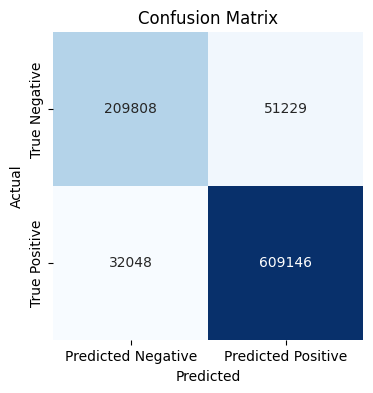

In [ ]:
acc, auc, sen, spc = evaluation(internal_labels, internal_preds)

In [ ]:
sim_acc.append(acc)
sim_auc.append(auc)
sim_sen.append(sen)
sim_spc.append(spc)

## TripSimAcin-AMR evaluation

(Phenotype prediction test)

Accuracy:  0.9161196207148067
ROC-AUC:  0.7882893685051958
Sensitivity:  0.9432454036770583
Specificity:  0.6333333333333333


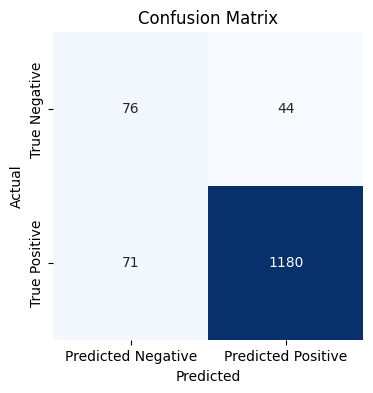

In [ ]:
acc, auc, sen, spc = evaluation(test_labels, aggre_preds)

In [ ]:
phen_acc.append(acc)
phen_auc.append(auc)
phen_sen.append(sen)
phen_spc.append(spc)

# Round 6

In [ ]:
# Making triplets
triplet, pairedLabels =  make_balanced_triplets(data, labels, drugs, 400)

In [ ]:
print(len(triplet))
print(len(triplet[0]))
print(len(pairedLabels))
print(pairedLabels[0])

19200
5689
19200
[1 0]


Preparing data

In [ ]:
triplet = np.asarray(triplet)
triplet.shape

(19200, 5689)

In [ ]:
pairedLabels = np.asarray(pairedLabels)
pairedLabels.shape

(19200, 2)

Training

In [ ]:
siamese_net = create_siamese_model(input_shape1, input_shape2, input_shape3)

In [ ]:
num_epochs=10
history=History()
siamese_net = create_siamese_model(input_shape1, input_shape2, input_shape3)

print("Round: 1 ---> 1-10")
history = siamese_net.fit([[triplet[:, :2693],
                           triplet[:, 2693:(2693+2693)]],
                           triplet[:, (2693+2693):]], pairedLabels[:, 0],
                          epochs=num_epochs, batch_size=64, verbose=1, callbacks=history)

for i in range(25-1):
  print("Round: ", i+2, '--->', (i+1)*10+1, '-', (i+2)*10)

  triplet, pairedLabels =  make_balanced_triplets(data, labels, drugs, 400)

  history = siamese_net.fit([[triplet[:, :2693],
                           triplet[:, 2693:(2693+2693)]],
                           triplet[:, (2693+2693):]], pairedLabels[:, 0],
                          epochs=num_epochs, batch_size=64, verbose=1, callbacks=history)

Round: 1 ---> 1-10
Epoch 1/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - accuracy: 0.5049 - auc-roc: 0.5067 - loss: 0.7738
Epoch 2/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.4980 - auc-roc: 0.4991 - loss: 0.7070
Epoch 3/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.5032 - auc-roc: 0.4995 - loss: 0.7013
Epoch 4/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.5129 - auc-roc: 0.5129 - loss: 0.6963
Epoch 5/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.5294 - auc-roc: 0.5506 - loss: 0.6811
Epoch 6/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.7377 - auc-roc: 0.8278 - loss: 0.5068
Epoch 7/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.7728 - auc-roc: 0.8617 - loss: 0.4641
Epoch 8/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.7837 - auc-roc: 0.8759 - loss: 0.4410
Epoch 9/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8070 - auc-roc: 0.8921 - loss: 0.4167
Epoch 10/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s

## Validation

In [ ]:
test_labels = np.asarray(external_test_labels)
train_labels = np.asarray(labels)

In [ ]:
# splitting external_test_set to set of susceptible and resistant ones:
x0_test, x1_test, index0_test, index1_test = RS_splitter(external_test_set, test_labels)

In [ ]:
print(len(x0_test))
print(len(x0_test[0]))
print(len(x1_test))
print(len(x1_test[0]))

120
2996
1251
2996


In [ ]:
x0_train, x1_train, index0_train, index1_train = RS_splitter(data, labels)

In [ ]:
print(len(x0_train))
print(len(x0_train[0]))
print(len(x1_train))
print(len(x1_train[0]))

1940
2996
4690
2996


In [ ]:
x0_train = np.asarray(x0_train)
x1_train = np.asarray(x1_train)

## Procedure (Per test sample)

In [ ]:
test_labels = []  # True labels for test samples.
aggre_preds = [] # Aggregated pred values for each sample, by DefineTest2 func.
internal_labels = [] # Labels form ExternalTest2 for internal test
internal_preds = [] # internal_labels corresponding predictions
test_indices = []

for c, i in enumerate(x0_test):      #x0_test, x1_test, x0_train, x1_train
  data, labels, indexSample = ExternalTest([i], [], x0_train, x1_train) # makes i couple with x0_train & x1_train
  internal_labels += labels.tolist()
  predd = siamese_net.predict([[data[:, :2693],
                           data[:, 2693:(2693+2693)]],
                           data[:, (2693+2693):]], verbose=0)
  internal_preds += predd.tolist()
  y_pred, label = DefineTest2([i], [], indexSample, predd)
  aggre_preds.append(y_pred[0][0]) # y_pred ---> [array([0.5], dtype=float32)]
  test_labels.append(label[0])
  test_indices.append(index0_test[c]) # Index in original data


for c, i in enumerate(x1_test):
  data, labels, indexSample = ExternalTest([], [i], x0_train, x1_train)
  internal_labels += labels.tolist()
  predd = siamese_net.predict([[data[:, :2693],
                           data[:, 2693:(2693+2693)]],
                           data[:, (2693+2693):]], verbose=0)
  internal_preds += predd.tolist()
  y_pred, label = DefineTest2([], [i], indexSample, predd)
  aggre_preds.append(y_pred[0][0])
  test_labels.append(label[0])
  test_indices.append(index1_test[c]) # Index in original data

In [ ]:
temp = [i[0] for i in internal_preds]
internal_preds = temp

## TSA-Net evaluation

(Similarity test)

Accuracy:  0.8895338333530991
ROC-AUC:  0.8634864703399137
Sensitivity:  0.9253049779006042
Specificity:  0.8016679627792229


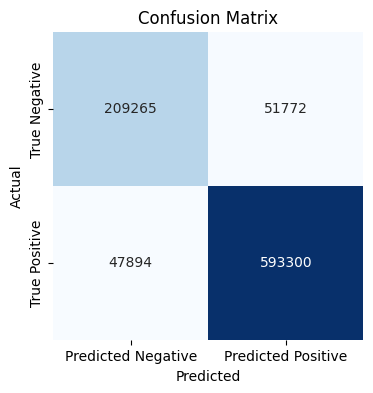

In [ ]:
acc, auc, sen, spc = evaluation(internal_labels, internal_preds)

In [ ]:
sim_acc.append(acc)
sim_auc.append(auc)
sim_sen.append(sen)
sim_spc.append(spc)

## TripSimAcin-AMR evaluation

(Phenotype prediction test)

Accuracy:  0.8927789934354485
ROC-AUC:  0.8207034372502
Sensitivity:  0.9080735411670664
Specificity:  0.7333333333333333


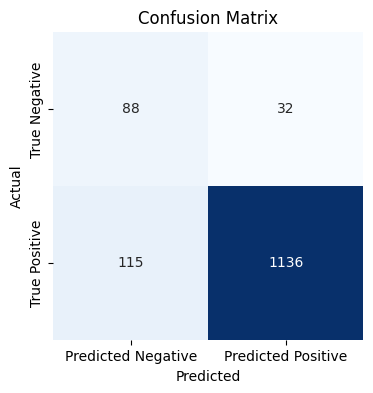

In [ ]:
acc, auc, sen, spc = evaluation(test_labels, aggre_preds)

In [ ]:
phen_acc.append(acc)
phen_auc.append(auc)
phen_sen.append(sen)
phen_spc.append(spc)

# Round 7

In [ ]:
# Making triplets
triplet, pairedLabels =  make_balanced_triplets(data, labels, drugs, 400)

In [ ]:
print(len(triplet))
print(len(triplet[0]))
print(len(pairedLabels))
print(pairedLabels[0])

19200
5689
19200
[1 0]


Preparing data

In [ ]:
triplet = np.asarray(triplet)
triplet.shape

(19200, 5689)

In [ ]:
pairedLabels = np.asarray(pairedLabels)
pairedLabels.shape

(19200, 2)

Training

In [ ]:
siamese_net = create_siamese_model(input_shape1, input_shape2, input_shape3)

In [ ]:
num_epochs=10
history=History()
siamese_net = create_siamese_model(input_shape1, input_shape2, input_shape3)

print("Round: 1 ---> 1-10")
history = siamese_net.fit([[triplet[:, :2693],
                           triplet[:, 2693:(2693+2693)]],
                           triplet[:, (2693+2693):]], pairedLabels[:, 0],
                          epochs=num_epochs, batch_size=64, verbose=1, callbacks=history)

for i in range(25-1):
  print("Round: ", i+2, '--->', (i+1)*10+1, '-', (i+2)*10)

  triplet, pairedLabels =  make_balanced_triplets(data, labels, drugs, 400)

  history = siamese_net.fit([[triplet[:, :2693],
                           triplet[:, 2693:(2693+2693)]],
                           triplet[:, (2693+2693):]], pairedLabels[:, 0],
                          epochs=num_epochs, batch_size=64, verbose=1, callbacks=history)

Round: 1 ---> 1-10
Epoch 1/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - accuracy: 0.5031 - auc-roc: 0.5066 - loss: 0.7979
Epoch 2/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.4926 - auc-roc: 0.4875 - loss: 0.7138
Epoch 3/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.5044 - auc-roc: 0.5107 - loss: 0.7004
Epoch 4/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6306 - auc-roc: 0.6945 - loss: 0.6124
Epoch 5/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7423 - auc-roc: 0.8417 - loss: 0.4823
Epoch 6/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7738 - auc-roc: 0.8659 - loss: 0.4535
Epoch 7/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7930 - auc-roc: 0.8858 - loss: 0.4241
Epoch 8/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.8178 - auc-roc: 0.9074 - loss: 0.3863
Epoch 9/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8337 - auc-roc: 0.9230 - loss: 0.3526
Epoch 10/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 3s 

## Validation

In [ ]:
test_labels = np.asarray(external_test_labels)
train_labels = np.asarray(labels)

In [ ]:
# splitting external_test_set to set of susceptible and resistant ones:
x0_test, x1_test, index0_test, index1_test = RS_splitter(external_test_set, test_labels)

In [ ]:
print(len(x0_test))
print(len(x0_test[0]))
print(len(x1_test))
print(len(x1_test[0]))

120
2996
1251
2996


In [ ]:
x0_train, x1_train, index0_train, index1_train = RS_splitter(data, labels)

In [ ]:
print(len(x0_train))
print(len(x0_train[0]))
print(len(x1_train))
print(len(x1_train[0]))

1940
2996
4690
2996


In [ ]:
x0_train = np.asarray(x0_train)
x1_train = np.asarray(x1_train)

## Procedure (Per test sample)

In [ ]:
test_labels = []  # True labels for test samples.
aggre_preds = [] # Aggregated pred values for each sample, by DefineTest2 func.
internal_labels = [] # Labels form ExternalTest2 for internal test
internal_preds = [] # internal_labels corresponding predictions
test_indices = []

for c, i in enumerate(x0_test):      #x0_test, x1_test, x0_train, x1_train
  data, labels, indexSample = ExternalTest([i], [], x0_train, x1_train) # makes i couple with x0_train & x1_train
  internal_labels += labels.tolist()
  predd = siamese_net.predict([[data[:, :2693],
                           data[:, 2693:(2693+2693)]],
                           data[:, (2693+2693):]], verbose=0)
  internal_preds += predd.tolist()
  y_pred, label = DefineTest2([i], [], indexSample, predd)
  aggre_preds.append(y_pred[0][0]) # y_pred ---> [array([0.5], dtype=float32)]
  test_labels.append(label[0])
  test_indices.append(index0_test[c]) # Index in original data


for c, i in enumerate(x1_test):
  data, labels, indexSample = ExternalTest([], [i], x0_train, x1_train)
  internal_labels += labels.tolist()
  predd = siamese_net.predict([[data[:, :2693],
                           data[:, 2693:(2693+2693)]],
                           data[:, (2693+2693):]], verbose=0)
  internal_preds += predd.tolist()
  y_pred, label = DefineTest2([], [i], indexSample, predd)
  aggre_preds.append(y_pred[0][0])
  test_labels.append(label[0])
  test_indices.append(index1_test[c]) # Index in original data

In [ ]:
temp = [i[0] for i in internal_preds]
internal_preds = temp

## TSA-Net evaluation

(Similarity test)

Accuracy:  0.9039824612543794
ROC-AUC:  0.8752111170732338
Sensitivity:  0.9434944806096127
Specificity:  0.806927753536855


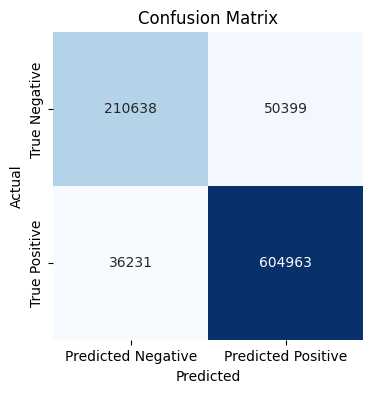

In [ ]:
acc, auc, sen, spc = evaluation(internal_labels, internal_preds)

In [ ]:
sim_acc.append(acc)
sim_auc.append(auc)
sim_sen.append(sen)
sim_spc.append(spc)

## TripSimAcin-AMR evaluation

(Phenotype prediction test)

Accuracy:  0.9095550692924872
ROC-AUC:  0.7959932054356514
Sensitivity:  0.9336530775379697
Specificity:  0.6583333333333333


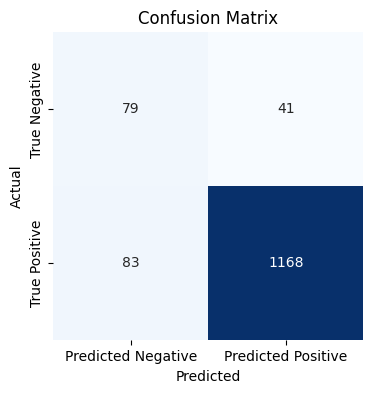

In [ ]:
acc, auc, sen, spc = evaluation(test_labels, aggre_preds)

In [ ]:
phen_acc.append(acc)
phen_auc.append(auc)
phen_sen.append(sen)
phen_spc.append(spc)

# Round 8

In [ ]:
# Making triplets
triplet, pairedLabels =  make_balanced_triplets(data, labels, drugs, 400)

In [ ]:
print(len(triplet))
print(len(triplet[0]))
print(len(pairedLabels))
print(pairedLabels[0])

19200
5689
19200
[1 0]


Preparing data

In [ ]:
triplet = np.asarray(triplet)
triplet.shape

(19200, 5689)

In [ ]:
pairedLabels = np.asarray(pairedLabels)
pairedLabels.shape

(19200, 2)

Training

In [ ]:
siamese_net = create_siamese_model(input_shape1, input_shape2, input_shape3)

In [ ]:
num_epochs=10
history=History()
siamese_net = create_siamese_model(input_shape1, input_shape2, input_shape3)

print("Round: 1 ---> 1-10")
history = siamese_net.fit([[triplet[:, :2693],
                           triplet[:, 2693:(2693+2693)]],
                           triplet[:, (2693+2693):]], pairedLabels[:, 0],
                          epochs=num_epochs, batch_size=64, verbose=1, callbacks=history)

for i in range(25-1):
  print("Round: ", i+2, '--->', (i+1)*10+1, '-', (i+2)*10)

  triplet, pairedLabels =  make_balanced_triplets(data, labels, drugs, 400)

  history = siamese_net.fit([[triplet[:, :2693],
                           triplet[:, 2693:(2693+2693)]],
                           triplet[:, (2693+2693):]], pairedLabels[:, 0],
                          epochs=num_epochs, batch_size=64, verbose=1, callbacks=history)

Round: 1 ---> 1-10
Epoch 1/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - accuracy: 0.5003 - auc-roc: 0.4955 - loss: 0.7942
Epoch 2/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4918 - auc-roc: 0.4937 - loss: 0.7104
Epoch 3/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5008 - auc-roc: 0.5049 - loss: 0.7021
Epoch 4/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5149 - auc-roc: 0.5161 - loss: 0.6965
Epoch 5/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7036 - auc-roc: 0.7908 - loss: 0.5480
Epoch 6/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.7680 - auc-roc: 0.8598 - loss: 0.4654
Epoch 7/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7859 - auc-roc: 0.8734 - loss: 0.4456
Epoch 8/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8070 - auc-roc: 0.8909 - loss: 0.4204
Epoch 9/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8207 - auc-roc: 0.9065 - loss: 0.3883
Epoch 10/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 

## Validation

In [ ]:
test_labels = np.asarray(external_test_labels)
train_labels = np.asarray(labels)

In [ ]:
# splitting external_test_set to set of susceptible and resistant ones:
x0_test, x1_test, index0_test, index1_test = RS_splitter(external_test_set, test_labels)

In [ ]:
print(len(x0_test))
print(len(x0_test[0]))
print(len(x1_test))
print(len(x1_test[0]))

120
2996
1251
2996


In [ ]:
x0_train, x1_train, index0_train, index1_train = RS_splitter(data, labels)

In [ ]:
print(len(x0_train))
print(len(x0_train[0]))
print(len(x1_train))
print(len(x1_train[0]))

1940
2996
4690
2996


In [ ]:
x0_train = np.asarray(x0_train)
x1_train = np.asarray(x1_train)

## Procedure (Per test sample)

In [ ]:
test_labels = []  # True labels for test samples.
aggre_preds = [] # Aggregated pred values for each sample, by DefineTest2 func.
internal_labels = [] # Labels form ExternalTest2 for internal test
internal_preds = [] # internal_labels corresponding predictions
test_indices = []

for c, i in enumerate(x0_test):      #x0_test, x1_test, x0_train, x1_train
  data, labels, indexSample = ExternalTest([i], [], x0_train, x1_train) # makes i couple with x0_train & x1_train
  internal_labels += labels.tolist()
  predd = siamese_net.predict([[data[:, :2693],
                           data[:, 2693:(2693+2693)]],
                           data[:, (2693+2693):]], verbose=0)
  internal_preds += predd.tolist()
  y_pred, label = DefineTest2([i], [], indexSample, predd)
  aggre_preds.append(y_pred[0][0]) # y_pred ---> [array([0.5], dtype=float32)]
  test_labels.append(label[0])
  test_indices.append(index0_test[c]) # Index in original data


for c, i in enumerate(x1_test):
  data, labels, indexSample = ExternalTest([], [i], x0_train, x1_train)
  internal_labels += labels.tolist()
  predd = siamese_net.predict([[data[:, :2693],
                           data[:, 2693:(2693+2693)]],
                           data[:, (2693+2693):]], verbose=0)
  internal_preds += predd.tolist()
  y_pred, label = DefineTest2([], [i], indexSample, predd)
  aggre_preds.append(y_pred[0][0])
  test_labels.append(label[0])
  test_indices.append(index1_test[c]) # Index in original data

In [ ]:
temp = [i[0] for i in internal_preds]
internal_preds = temp

## TSA-Net evaluation

(Similarity test)

Accuracy:  0.9024229936679188
ROC-AUC:  0.8776037733480847
Sensitivity:  0.9365075156660855
Specificity:  0.8187000310300838


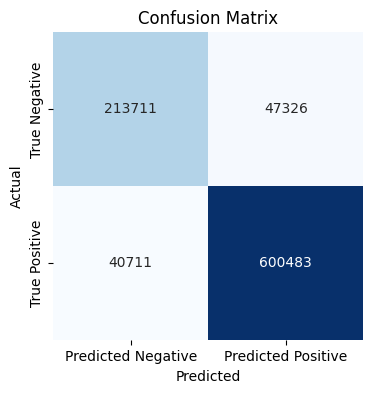

In [ ]:
acc, auc, sen, spc = evaluation(internal_labels, internal_preds)

In [ ]:
sim_acc.append(acc)
sim_auc.append(auc)
sim_sen.append(sen)
sim_spc.append(spc)

## TripSimAcin-AMR evaluation

(Phenotype prediction test)

Accuracy:  0.9051787016776076
ROC-AUC:  0.8237310151878496
Sensitivity:  0.9224620303756994
Specificity:  0.725


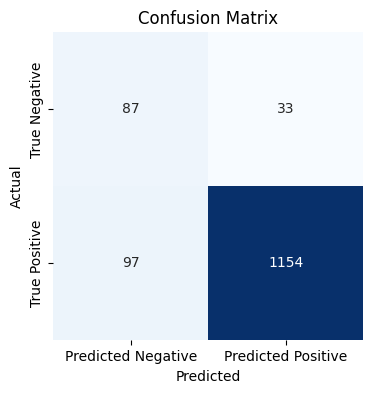

In [ ]:
acc, auc, sen, spc = evaluation(test_labels, aggre_preds)

In [ ]:
phen_acc.append(acc)
phen_auc.append(auc)
phen_sen.append(sen)
phen_spc.append(spc)

# Round 9

In [ ]:
# Making triplets
triplet, pairedLabels =  make_balanced_triplets(data, labels, drugs, 400)

In [ ]:
print(len(triplet))
print(len(triplet[0]))
print(len(pairedLabels))
print(pairedLabels[0])

19200
5689
19200
[1 0]


Preparing data

In [ ]:
triplet = np.asarray(triplet)
triplet.shape

(19200, 5689)

In [ ]:
pairedLabels = np.asarray(pairedLabels)
pairedLabels.shape

(19200, 2)

Training

In [ ]:
siamese_net = create_siamese_model(input_shape1, input_shape2, input_shape3)

In [ ]:
num_epochs=10
history=History()
siamese_net = create_siamese_model(input_shape1, input_shape2, input_shape3)

print("Round: 1 ---> 1-10")
history = siamese_net.fit([[triplet[:, :2693],
                           triplet[:, 2693:(2693+2693)]],
                           triplet[:, (2693+2693):]], pairedLabels[:, 0],
                          epochs=num_epochs, batch_size=64, verbose=1, callbacks=history)

for i in range(25-1):
  print("Round: ", i+2, '--->', (i+1)*10+1, '-', (i+2)*10)

  triplet, pairedLabels =  make_balanced_triplets(data, labels, drugs, 400)

  history = siamese_net.fit([[triplet[:, :2693],
                           triplet[:, 2693:(2693+2693)]],
                           triplet[:, (2693+2693):]], pairedLabels[:, 0],
                          epochs=num_epochs, batch_size=64, verbose=1, callbacks=history)

Round: 1 ---> 1-10
Epoch 1/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - accuracy: 0.5056 - auc-roc: 0.5104 - loss: 0.7974
Epoch 2/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.4976 - auc-roc: 0.4995 - loss: 0.7130
Epoch 3/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.5156 - auc-roc: 0.5241 - loss: 0.6974
Epoch 4/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.7046 - auc-roc: 0.7931 - loss: 0.5443
Epoch 5/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.7525 - auc-roc: 0.8503 - loss: 0.4745
Epoch 6/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.7805 - auc-roc: 0.8723 - loss: 0.4448
Epoch 7/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7967 - auc-roc: 0.8861 - loss: 0.4263
Epoch 8/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8151 - auc-roc: 0.9043 - loss: 0.3898
Epoch 9/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8344 - auc-roc: 0.9204 - loss: 0.3605
Epoch 10/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 

## Validation

In [ ]:
test_labels = np.asarray(external_test_labels)
train_labels = np.asarray(labels)

In [ ]:
# splitting external_test_set to set of susceptible and resistant ones:
x0_test, x1_test, index0_test, index1_test = RS_splitter(external_test_set, test_labels)

In [ ]:
print(len(x0_test))
print(len(x0_test[0]))
print(len(x1_test))
print(len(x1_test[0]))

120
2996
1251
2996


In [ ]:
x0_train, x1_train, index0_train, index1_train = RS_splitter(data, labels)

In [ ]:
print(len(x0_train))
print(len(x0_train[0]))
print(len(x1_train))
print(len(x1_train[0]))

1940
2996
4690
2996


In [ ]:
x0_train = np.asarray(x0_train)
x1_train = np.asarray(x1_train)

## Procedure (Per test sample)

In [ ]:
test_labels = []  # True labels for test samples.
aggre_preds = [] # Aggregated pred values for each sample, by DefineTest2 func.
internal_labels = [] # Labels form ExternalTest2 for internal test
internal_preds = [] # internal_labels corresponding predictions
test_indices = []

for c, i in enumerate(x0_test):      #x0_test, x1_test, x0_train, x1_train
  data, labels, indexSample = ExternalTest([i], [], x0_train, x1_train) # makes i couple with x0_train & x1_train
  internal_labels += labels.tolist()
  predd = siamese_net.predict([[data[:, :2693],
                           data[:, 2693:(2693+2693)]],
                           data[:, (2693+2693):]], verbose=0)
  internal_preds += predd.tolist()
  y_pred, label = DefineTest2([i], [], indexSample, predd)
  aggre_preds.append(y_pred[0][0]) # y_pred ---> [array([0.5], dtype=float32)]
  test_labels.append(label[0])
  test_indices.append(index0_test[c]) # Index in original data


for c, i in enumerate(x1_test):
  data, labels, indexSample = ExternalTest([], [i], x0_train, x1_train)
  internal_labels += labels.tolist()
  predd = siamese_net.predict([[data[:, :2693],
                           data[:, 2693:(2693+2693)]],
                           data[:, (2693+2693):]], verbose=0)
  internal_preds += predd.tolist()
  y_pred, label = DefineTest2([], [i], indexSample, predd)
  aggre_preds.append(y_pred[0][0])
  test_labels.append(label[0])
  test_indices.append(index1_test[c]) # Index in original data

In [ ]:
temp = [i[0] for i in internal_preds]
internal_preds = temp

## TSA-Net evaluation

(Similarity test)

Accuracy:  0.8822585346768178
ROC-AUC:  0.8560693551115192
Sensitivity:  0.9182244375337262
Specificity:  0.7939142726893123


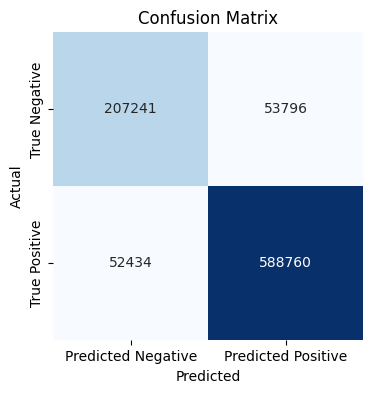

In [ ]:
acc, auc, sen, spc = evaluation(internal_labels, internal_preds)

In [ ]:
sim_acc.append(acc)
sim_auc.append(auc)
sim_sen.append(sen)
sim_spc.append(spc)

## TripSimAcin-AMR evaluation

(Phenotype prediction test)

Accuracy:  0.8935083880379285
ROC-AUC:  0.8211031175059953
Sensitivity:  0.9088729016786571
Specificity:  0.7333333333333333


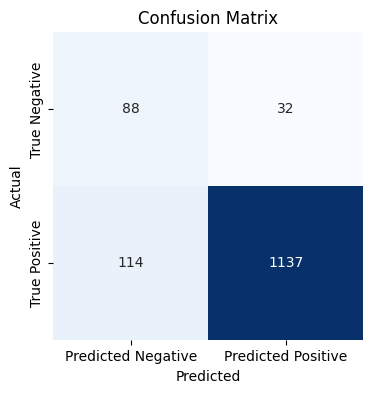

In [ ]:
acc, auc, sen, spc = evaluation(test_labels, aggre_preds)

In [ ]:
phen_acc.append(acc)
phen_auc.append(auc)
phen_sen.append(sen)
phen_spc.append(spc)

# Round 10

In [ ]:
# Making triplets
triplet, pairedLabels =  make_balanced_triplets(data, labels, drugs, 400)

In [ ]:
print(len(triplet))
print(len(triplet[0]))
print(len(pairedLabels))
print(pairedLabels[0])

19200
5689
19200
[1 0]


Preparing data

In [ ]:
triplet = np.asarray(triplet)
triplet.shape

(19200, 5689)

In [ ]:
pairedLabels = np.asarray(pairedLabels)
pairedLabels.shape

(19200, 2)

Training

In [ ]:
siamese_net = create_siamese_model(input_shape1, input_shape2, input_shape3)

In [ ]:
num_epochs=10
history=History()
siamese_net = create_siamese_model(input_shape1, input_shape2, input_shape3)

print("Round: 1 ---> 1-10")
history = siamese_net.fit([[triplet[:, :2693],
                           triplet[:, 2693:(2693+2693)]],
                           triplet[:, (2693+2693):]], pairedLabels[:, 0],
                          epochs=num_epochs, batch_size=64, verbose=1, callbacks=history)

for i in range(25-1):
  print("Round: ", i+2, '--->', (i+1)*10+1, '-', (i+2)*10)

  triplet, pairedLabels =  make_balanced_triplets(data, labels, drugs, 400)

  history = siamese_net.fit([[triplet[:, :2693],
                           triplet[:, 2693:(2693+2693)]],
                           triplet[:, (2693+2693):]], pairedLabels[:, 0],
                          epochs=num_epochs, batch_size=64, verbose=1, callbacks=history)

Round: 1 ---> 1-10
Epoch 1/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.4987 - auc-roc: 0.4973 - loss: 0.7697
Epoch 2/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.5099 - auc-roc: 0.5092 - loss: 0.7037
Epoch 3/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5034 - auc-roc: 0.5029 - loss: 0.7004
Epoch 4/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5850 - auc-roc: 0.6322 - loss: 0.6490
Epoch 5/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7418 - auc-roc: 0.8386 - loss: 0.4907
Epoch 6/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7696 - auc-roc: 0.8648 - loss: 0.4574
Epoch 7/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7940 - auc-roc: 0.8844 - loss: 0.4283
Epoch 8/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.8257 - auc-roc: 0.9090 - loss: 0.3851
Epoch 9/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.8348 - auc-roc: 0.9210 - loss: 0.3572
Epoch 10/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 

## Validation

In [ ]:
test_labels = np.asarray(external_test_labels)
train_labels = np.asarray(labels)

In [ ]:
# splitting external_test_set to set of susceptible and resistant ones:
x0_test, x1_test, index0_test, index1_test = RS_splitter(external_test_set, test_labels)

In [ ]:
print(len(x0_test))
print(len(x0_test[0]))
print(len(x1_test))
print(len(x1_test[0]))

120
2996
1251
2996


In [ ]:
x0_train, x1_train, index0_train, index1_train = RS_splitter(data, labels)

In [ ]:
print(len(x0_train))
print(len(x0_train[0]))
print(len(x1_train))
print(len(x1_train[0]))

1940
2996
4690
2996


In [ ]:
x0_train = np.asarray(x0_train)
x1_train = np.asarray(x1_train)

## Procedure (Per test sample)

In [ ]:
test_labels = []  # True labels for test samples.
aggre_preds = [] # Aggregated pred values for each sample, by DefineTest2 func.
internal_labels = [] # Labels form ExternalTest2 for internal test
internal_preds = [] # internal_labels corresponding predictions
test_indices = []

for c, i in enumerate(x0_test):      #x0_test, x1_test, x0_train, x1_train
  data, labels, indexSample = ExternalTest([i], [], x0_train, x1_train) # makes i couple with x0_train & x1_train
  internal_labels += labels.tolist()
  predd = siamese_net.predict([[data[:, :2693],
                           data[:, 2693:(2693+2693)]],
                           data[:, (2693+2693):]], verbose=0)
  internal_preds += predd.tolist()
  y_pred, label = DefineTest2([i], [], indexSample, predd)
  aggre_preds.append(y_pred[0][0]) # y_pred ---> [array([0.5], dtype=float32)]
  test_labels.append(label[0])
  test_indices.append(index0_test[c]) # Index in original data


for c, i in enumerate(x1_test):
  data, labels, indexSample = ExternalTest([], [i], x0_train, x1_train)
  internal_labels += labels.tolist()
  predd = siamese_net.predict([[data[:, :2693],
                           data[:, 2693:(2693+2693)]],
                           data[:, (2693+2693):]], verbose=0)
  internal_preds += predd.tolist()
  y_pred, label = DefineTest2([], [i], indexSample, predd)
  aggre_preds.append(y_pred[0][0])
  test_labels.append(label[0])
  test_indices.append(index1_test[c]) # Index in original data

In [ ]:
temp = [i[0] for i in internal_preds]
internal_preds = temp

## TSA-Net evaluation

(Similarity test)

Accuracy:  0.9127850849726955
ROC-AUC:  0.8861750828892078
Sensitivity:  0.9493289082555357
Specificity:  0.8230212575228799


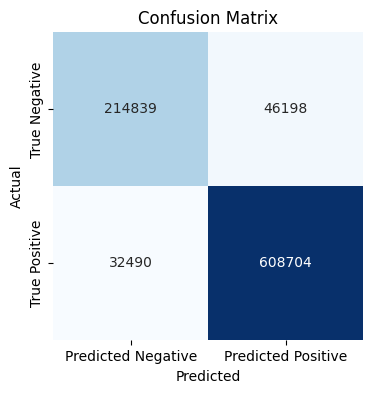

In [ ]:
acc, auc, sen, spc = evaluation(internal_labels, internal_preds)

In [ ]:
sim_acc.append(acc)
sim_auc.append(auc)
sim_sen.append(sen)
sim_spc.append(spc)

## TripSimAcin-AMR evaluation

(Phenotype prediction test)

Accuracy:  0.9153902261123268
ROC-AUC:  0.7841227018385292
Sensitivity:  0.9432454036770583
Specificity:  0.625


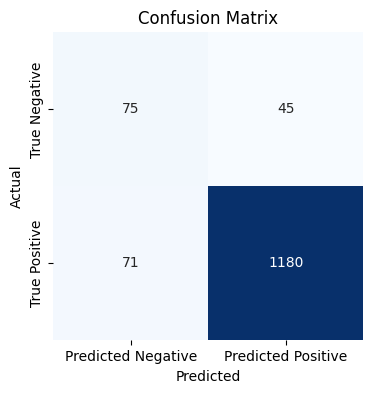

In [ ]:
acc, auc, sen, spc = evaluation(test_labels, aggre_preds)

In [ ]:
phen_acc.append(acc)
phen_auc.append(auc)
phen_sen.append(sen)
phen_spc.append(spc)

# Results

In [ ]:
print("similarity accuracies: ", sim_acc)
print("average: ", sum(sim_acc)/len(sim_acc))

similarity accuracies:  [0.895, 0.8899, 0.8803, 0.8907219991332597, 0.9076988044081837, 0.8895338333530991, 0.9039824612543794, 0.9024229936679188, 0.8822585346768178, 0.9127850849726955]
averrage:  0.8954603711466355


In [ ]:
print("similarity aucs: ", sim_auc)
print("average: ", sum(sim_auc)/len(sim_auc))

similarity aucs:  [0.8624, 0.8577, 0.849, 0.8654012707650702, 0.8768831874338086, 0.8634864703399137, 0.8752111170732338, 0.8776037733480847, 0.8560693551115192, 0.8861750828892078]
averrage:  0.8669930256960837


In [ ]:
print("similarity sensitivities: ", sim_sen)
print("average: ", sum(sim_sen)/len(sim_sen))

similarity sensitivities:  [0.9398, 0.9342, 0.9233, 0.9254952479280841, 0.9500182472075535, 0.9253049779006042, 0.9434944806096127, 0.9365075156660855, 0.9182244375337262, 0.9493289082555357]
averrage:  0.9345673815101202


In [ ]:
print("similarity specificities: ", sim_spc)
print("average: ", sum(sim_spc)/len(sim_spc))

similarity specificities:  [0.785, 0.7813, 0.7747, 0.8053072936020564, 0.8037481276600635, 0.8016679627792229, 0.806927753536855, 0.8187000310300838, 0.7939142726893123, 0.8230212575228799]
averrage:  0.7994286698820474


In [ ]:
print("Phenotype accuracies: ", phen_acc)
print("average: ", sum(phen_acc)/len(phen_acc))

Phenotype accuracies:  [0.9022, 0.8956, 0.8913, 0.9008023340627279, 0.9161196207148067, 0.8927789934354485, 0.9095550692924872, 0.9051787016776076, 0.8935083880379285, 0.9153902261123268]
averrage:  0.9022433333333334


In [ ]:
print("Phenotype aucs: ", phen_auc)
print("average: ", sum(phen_auc)/len(phen_auc))

Phenotype aucs:  [0.8221, 0.7959, 0.7935, 0.813798960831335, 0.7882893685051958, 0.8207034372502, 0.7959932054356514, 0.8237310151878496, 0.8211031175059953, 0.7841227018385292]
averrage:  0.8059241806554756


In [ ]:
print("Phenotype sensitivities: ", phen_sen)
print("average: ", sum(phen_sen)/len(phen_sen))

Phenotype sensitivities:  [0.9192, 0.9168, 0.912, 0.9192645883293366, 0.9432454036770583, 0.9080735411670664, 0.9336530775379697, 0.9224620303756994, 0.9088729016786571, 0.9432454036770583]
averrage:  0.9226816946442847


In [ ]:
print("Phenotype specificities: ", phen_spc)
print("average: ", sum(phen_spc)/len(phen_spc))

Phenotype specificities:  [0.725, 0.675, 0.675, 0.7083333333333334, 0.6333333333333333, 0.7333333333333333, 0.6583333333333333, 0.725, 0.7333333333333333, 0.625]
averrage:  0.6891666666666667
